In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore
from natsort import natsorted

from __init__ import *
import snmcseq_utils
from snmcseq_utils import cd
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_labels 
from CEMBA_run_tsne import run_tsne
from CEMBA_clustering_louvain_jaccard import louvain_jaccard
from CEMBA_update_mysql import connect_sql 

In [2]:
import importlib
importlib.reload(snmcseq_utils)
# import CEMBA_clustering_louvain_jaccard
# importlib.reload(CEMBA_clustering_louvain_jaccard)
# from CEMBA_clustering_louvain_jaccard import louvain_jaccard

# import CEMBA_run_tsne
# importlib.reload(CEMBA_run_tsne)
# from CEMBA_run_tsne import run_tsne

log = create_logger()
ens = 'Ens10'
context = 'CH'

# snmCSeq preprocessing

In [3]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc


In [4]:
def gene_id_to_name(gene_id, df_genes):
    """df_genes
    """
    return df_genes.loc[gene_id, 'gene_name']


In [7]:
# get gene*cell matrix (methylation)
fm = os.path.join(PATH_ENSEMBLES, ens, 'binc', 'binc_m{}_100000_{}.tsv.bgz'.format(context, ens))
df_m = pd.read_table(fm, index_col=['chr', 'start'], compression='gzip')
print(df_m.shape)
df_m.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [9]:
# get tsne and clustering (methylation)
database = DATABASE
engine = connect_sql(database) 
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'
sql = """SELECT cell_name, tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}
        FROM {} 
        JOIN cells ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                                       ens, ens)

df_info_m = pd.read_sql(sql, engine, index_col='cell_name')
print(df_info_m.shape)
df_info_m.head()

(5352, 4)


,tsne_x_mCHmCG_ndim2_perp30,tsne_y_mCHmCG_ndim2_perp30,cluster_mCHmCG_lv_npc50_k30,annotation_mCHmCG_lv_npc50_k30
cell_name,,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,-17.9718,-45.7888,3,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,-72.3889,-32.8037,4,mL5-1
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,34.1628,-49.8856,1,mL4
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,-1.2001,-15.6003,2,mL2/3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,34.9378,-48.1781,1,mL4


In [4]:
# gene annotation
sql = """SELECT * FROM genes"""
df_genes = pd.read_sql(sql, engine, index_col='gene_id')
print(df_genes.shape)
df_genes.head()

NameError: name 'engine' is not defined

In [10]:
# cluster and annotation
df_clst_annot_m = df_info_m[['cluster_'+cluster_type, 'annotation_'+cluster_type]].groupby('cluster_'+cluster_type).first().fillna('Glia')
df_clst_annot_m.head()

,annotation_mCHmCG_lv_npc50_k30
cluster_mCHmCG_lv_npc50_k30,
1,mL4
2,mL2/3
3,mL2/3
4,mL5-1
5,mL6-2


In [11]:
# get gene*cluster matrix (methylation)
clusters_mc_c = snmcseq_utils.get_cluster_mc_c(ens, context, genome_regions='bin', 
                     cluster_col='cluster_'+cluster_type, database=database)
clusters_mcc = get_mcc(clusters_mc_c, base_call_cutoff=1000, sufficient_coverage_fraction=1)
clusters_mcc.columns = [col[:-len('_mcc')] 
                        + '_' + df_clst_annot_m.loc[int(col[len('cluster_'):-len('_mcc')]), 'annotation_'+cluster_type]
                        for col in clusters_mcc.columns]

# clusters_mcc.index = [gene_id_to_name(gene_id, df_genes) for gene_id in clusters_mcc.index]

print(clusters_mcc.shape)
clusters_mcc.head()

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
03/20/2018 02:07:59 PM Found bin*cell matrix in /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/binc/binc_mCH_100000_Ens10.tsv.bgz
03/20/2018 02:09:25 PM Output shape: (25475, 52)
03/20/2018 02:09:25 PM Getting mcc matrix from mc and c
03/20/2018 02:09:25 PM base_call_cutoff=1000, sufficient_coverage_fraction=1
03/20/2018 02:09:25 PM Matrix size before pruning... (25475, 52)
03/20/2018 02:09:25 PM Matrix size after pruning... (24777, 52)
03/20/2018 02:09:25 PM (24777, 26)
03/20/2018 02:09:25 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(24777, 26)


cluster_1_mL4  cluster_2_mL2/3  cluster_3_mL2/3  cluster_4_mL5-1  \
chr bin                                                                         
1   3000000       0.012124         0.014539         0.015911         0.018392   
    3100000       0.015257         0.018745         0.020027         0.022815   
    3200000       0.012925         0.017045         0.017723         0.014765   
    3300000       0.013315         0.016371         0.017103         0.013960   
    3400000       0.015311         0.017566         0.018930         0.014552   

             cluster_5_mL6-2  cluster_6_mL5-1  cluster_7_mDL-2  \
chr bin                                                          
1   3000000         0.013082         0.014420         0.014522   
    3100000         0.018267         0.017083         0.020640   
    3200000         0.012119         0.013341         0.014404   
    3300000         0.011019         0.012314         0.013889   
    3400000         0.012298         0.013296         0.015928   

             cluster_8_mDL-2  cluster_9_mSst-1  cluster_10_mL5-2  \
chr bin                                                            
1   3000000         0.012497          0.021809          0.026325   
    3100000         0.018315          0.023478          0.033087   
    3200000         0.015044          0.013708          0.036243   
    3300000         0.013502          0.011700          0.024982   
    3400000         0.015820          0.012657          0.029455   

                   ...         cluster_17_mNdnf-2  cluster_18_Glia  \
chr bin            ...                                               
1   3000000        ...                   0.013148         0.007453   
    3100000        ...                   0.014308         0.008461   
    3200000        ...                   0.013260         0.016920   
    3300000        ...                   0.012052         0.022893   
    3400000        ...                   0.015849         0.024728   

             cluster_19_mL4  cluster_20_mL6-2  cluster_21_Glia  \
chr bin                                                          
1   3000000        0.012217          0.014279         0.006914   
    3100000        0.014968          0.019353         0.007060   
    3200000        0.013620          0.013616         0.007431   
    3300000        0.013791          0.011581         0.007990   
    3400000        0.016176          0.012543         0.007549   

             cluster_22_mL6-2  cluster_23_Glia  cluster_24_mPv  \
chr bin                                                          
1   3000000          0.019625         0.006358        0.025746   
    3100000          0.022812         0.007266        0.027050   
    3200000          0.014670         0.007412        0.015673   
    3300000          0.012566         0.008024        0.012739   
    3400000          0.014558         0.007277        0.014191   

             cluster_25_mSst-1  cluster_26_mDL-3  
chr bin                                           
1   3000000           0.023903          0.013452  
    3100000           0.029990          0.020185  
    3200000           0.015314          0.018219  
    3300000           0.013155          0.016962  
    3400000           0.015209          0.019728  

[5 rows x 26 columns]

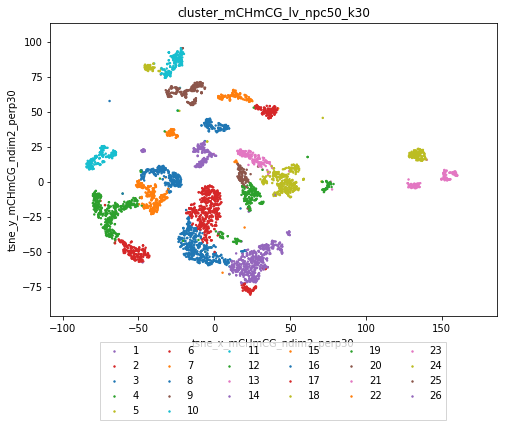

In [236]:
# plot clustering (methylation)
plot_tsne_labels(df_info_m, 
                 tx='tsne_x_'+tsne_type, 
                 ty='tsne_y_'+tsne_type, 
                 tc='cluster_'+cluster_type, 
                 legend_mode=1, s=2) 

# ATAC preprocessing

In [3]:
# get gene*cell matrix (ATAC)

# f = '/cndd/Public_Datasets/CEMBA/snATACSeq/Datasets/CEMBA_3C_171206/CEMBA_3C_171206_merged.gene10kb.counts.tsv'
f = '/cndd/projects/Public_Datasets/CEMBA/integrated/test/counts_corrected.tsv'
df = pd.read_table(f)
# remove chr
df['chr'] = [chrom[len('chr'):] for chrom in df['chr']]
# set index
df = df.set_index(['chr', 'start'])
print(df.shape)
df.head()


(25475, 9298)


AGCGATAGAACCAGGTAAGAGATGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTAATGACGTCAGGACGT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTAGGATAACATAGAGGC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTAGGCGAAG  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTATAGAGGC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTGTACTGAC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATTCGTTGTAATCTTA  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATTCGTTGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTGAAGTATGAGGCGAAG  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTGAAGTATGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

                          ...                 \
chr start                 ...                  
1   0                     ...                  
    100000                ...                  
    200000                ...                  
    300000                ...                  
    400000                ...                  

            TCTCGCGCTTAGCCTCTGCCTTACCAGGACGT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000       

In [4]:
# counts to logtpm
# gene_lengths = df_genes.loc[df.index, 'end'] - df_genes.loc[df.index, 'start']
# gene_lengths_flanking = gene_lengths + 1e4 

tmp = df/1e5
tmp = tmp.divide(tmp.sum(axis=0))*1e6
logtpm = np.log10(1 + tmp)

In [6]:
# tsne 
ti = time.time()
df_tsne = run_tsne(df, perp=50, n_pc=50, verbose=3, n_iter=2000)
print(df_tsne.shape)
df_tsne.head()

output = '/cndd/fangming/integration/tsne_ATAC_test_bin.tsv'
df_tsne.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
logging.info(time.time() - ti)

03/30/2018 11:59:18 PM Running tsne: 50 PC, 50 perp, 2 dim.
Input shape: (25475, 9298)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9298 samples in 0.016s...
[t-SNE] Computed neighbors for 9298 samples in 2.576s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9298
[t-SNE] Computed conditional probabilities for sample 2000 / 9298
[t-SNE] Computed conditional probabilities for sample 3000 / 9298
[t-SNE] Computed conditional probabilities for sample 4000 / 9298
[t-SNE] Computed conditional probabilities for sample 5000 / 9298
[t-SNE] Computed conditional probabilities for sample 6000 / 9298
[t-SNE] Computed conditional probabilities for sample 7000 / 9298
[t-SNE] Computed conditional probabilities for sample 8000 / 9298
[t-SNE] Computed conditional probabilities for sample 9000 / 9298
[t-SNE] Computed conditional probabilities for sample 9298 / 9298
[t-SNE] Mean sigma: 3.987222
[t-SNE] Computed conditional probabilities in 1.014s
[t-SNE] Iteration 50: error = 70.9358139, gradient norm = 0.0195276 (50 iterations in 13.882s)
[t-SNE] Iteration 100

03/31/2018 12:09:08 AM Done with tSNE. running time: 589.8475296497345 seconds.
03/31/2018 12:09:08 AM 590.2051062583923


[t-SNE] Iteration 2000: error = 1.4125823, gradient norm = 0.0000401 (50 iterations in 15.001s)
[t-SNE] Error after 2000 iterations: 1.412582
(9298, 2)


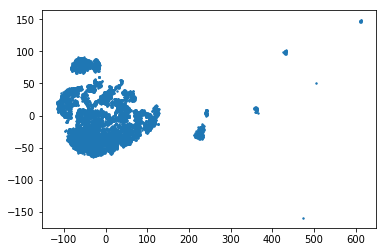

In [109]:
# plot tsne
fig, ax = plt.subplots()
ax.scatter(df_tsne['tsne_x'], df_tsne['tsne_y'], s=2)
# ax.set_xlim([-200, 200])
# ax.set_ylim([-100, 100])
plt.show()

In [5]:
# clustering
df_clst, clst_summary = louvain_jaccard(logtpm, n_pc=50, k=30, sub_ncells=None, output_file=None, sample_column_suffix=None)
output = '/cndd/fangming/integration/clustering_ATAC_test_bin.tsv'
df_clst.to_csv(output, sep='\t', header=True, index=True, na_rep='NA')
print(df_clst.shape)
df_clst.head()

03/30/2018 11:53:46 PM Begin louvain jaccard clustering
Input shape (n_obs, n_features): (9298, 25475)
03/30/2018 11:54:46 PM clustering summary: OrderedDict([('time', 60.060062885284424), ('n_cells', 9298), ('time_clst', 9.299817562103271), ('nclst', 27), ('k', 30), ('n_pc', 50)])


(9298, 1)


,cluster_ID
sample,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,cluster_4
AGCGATAGAACCAGGTAATGACGTCAGGACGT,cluster_8
AGCGATAGAACCAGGTAGGATAACATAGAGGC,cluster_12
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,cluster_4
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,cluster_7


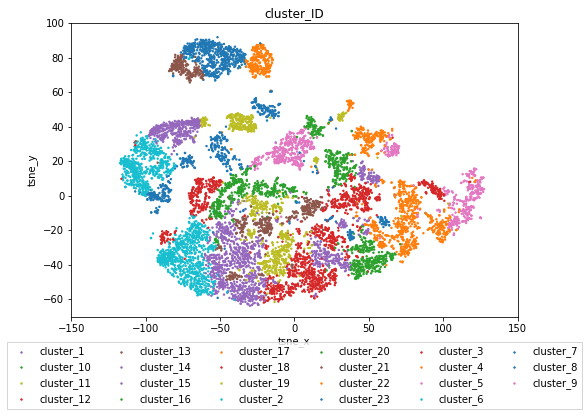

In [110]:
# plot clustering
df_info = pd.merge(df_tsne, df_clst, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=1, s=2, 
                 t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

In [13]:
f = '/cndd/fangming/integration/clustering_ATAC_test.tsv'
df_clst_atac2 = pd.read_table(f, index_col='sample')
df_clst_atac2.head()

,cluster_ID
sample,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,cluster_5
AGCGATAGAACCAGGTAATGACGTCAGGACGT,cluster_5
AGCGATAGAACCAGGTAGGATAACATAGAGGC,cluster_19
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,cluster_10
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,cluster_4


# ATAC From Rongxin

In [27]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_clst_atac = pd.read_table('XW45_cluster.txt', header=None, names=['sample', 'cluster_ID'], index_col='sample')
    df_tsne_atac = pd.read_table('XW45_tsne.txt', header=None, names=['sample', 'tsne_x', 'tsne_y'], index_col='sample')
#     df_atac = pd.read_table('XW45_gene.txt.gz')
print(df_clst_atac.shape)
print(df_tsne_atac.shape)
df_clst_atac.head()
df_tsne_atac.head()

(8567, 1)
(8567, 2)


,tsne_x,tsne_y
sample,,
AGCGATAGAACCAGGTAAGAGATGTATAGCCT,-9.268252,-26.684774
AGCGATAGAACCAGGTAATGACGTCAGGACGT,4.436012,26.133310
AGCGATAGAACCAGGTAGGATAACATAGAGGC,-18.538379,18.408741
AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,-5.263620,-22.532956
AGCGATAGAACCAGGTATAGCCTTATAGAGGC,6.972201,-8.754007


In [16]:
with cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_atac = pd.read_table('XW45_gene.txt.gz')
df_atac = df_atac.T
print(df_atac.shape)
df_atac.head()

(24848, 8567)


,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTAATGACGTCAGGACGT,AGCGATAGAACCAGGTAGGATAACATAGAGGC,AGCGATAGAACCAGGTATAGCCTTAGGCGAAG,AGCGATAGAACCAGGTATAGCCTTATAGAGGC,AGCGATAGAACCAGGTATAGCCTTGTACTGAC,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGAGGCGAAG,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,...,TCTCGCGCTTAGCCTCTTGGAAGTATAGAGGC,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTTATAGCCT
Xkr4,2.3293,0.9921,0.0740,1.6337,1.1935,1.3900,0.0000,1.5156,1.7755,1.0137,...,1.1744,1.2613,0.8783,1.1268,1.2383,2.0354,0.5448,1.4776,0.8248,1.5198
Ncaph2,0.7072,0.8949,0.4215,0.5603,0.4907,0.6041,1.3469,0.4354,1.2734,0.7676,...,1.2276,1.6495,1.0536,0.6606,0.4002,0.8459,0.5310,0.3135,0.5910,1.4047
Eif4enif1,0.5953,0.4285,2.9547,0.5595,0.3434,0.4247,2.5039,0.6048,0.8982,0.1843,...,0.6268,0.4233,0.0580,0.6102,0.4689,0.7383,0.3384,0.5968,0.3255,0.6695
Rgr,0.5147,0.2169,0.4826,0.1568,0.0824,0.1683,0.4756,0.4450,0.6172,0.1623,...,0.0668,0.0668,0.3163,1.0814,0.2927,0.4611,0.8932,1.2631,0.1776,0.1806
Mapkapk2,0.8165,0.7324,0.7347,0.6391,1.1717,1.1908,1.0460,1.5550,0.7866,0.5246,...,0.5236,0.8667,0.3547,0.7838,1.0622,0.6283,0.5235,2.6980,0.5169,1.3208


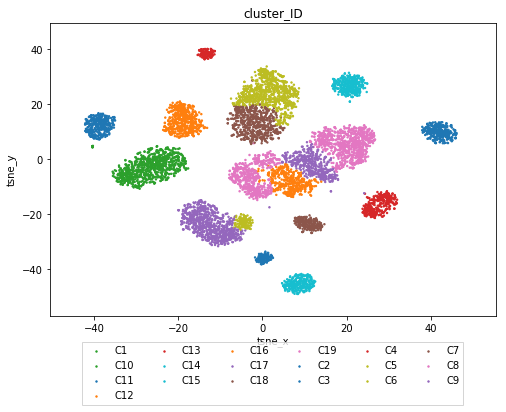

In [20]:
# plot clustering
df_info = pd.merge(df_tsne_atac, df_clst_atac, left_index=True, right_index=True)
plot_tsne_labels(df_info, tc='cluster_ID', legend_mode=1, s=2, 
#                  t_xlim=[-150, 150], t_ylim=[-70, 100]
                )

# Cluster-wise features 

In [42]:
df_clst = df_clst_atac
df_atac = df

print(df_atac.shape)
df_atac.head()

(25475, 9298)


AGCGATAGAACCAGGTAAGAGATGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTAATGACGTCAGGACGT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTAGGATAACATAGAGGC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTAGGCGAAG  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTATAGAGGC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATAGCCTTGTACTGAC  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATTCGTTGTAATCTTA  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTATTCGTTGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTGAAGTATGAGGCGAAG  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

            AGCGATAGAACCAGGTGAAGTATGTATAGCCT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000                                 0   

                          ...                 \
chr start                 ...                  
1   0                     ...                  
    100000                ...                  
    200000                ...                  
    300000                ...                  
    400000                ...                  

            TCTCGCGCTTAGCCTCTGCCTTACCAGGACGT  \
chr start                                      
1   0                                      0   
    100000                                 0   
    200000                                 0   
    300000                                 0   
    400000       

In [43]:
# get gene*cluster matrix 

clusters_atac = pd.DataFrame() 
for label, df_sub in df_clst.groupby('cluster_ID'):
    samples = df_sub.index.values
    samples = [sample for sample in samples if sample in df_atac.columns.tolist()]
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))
# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.head()

03/20/2018 03:04:04 PM Output shape: (25475, 19)


C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  C13  \
chr start                                                                     
1   0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
    100000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
    200000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
    300000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
    400000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            C14  C15  C16  C17  C18  C19  
chr start                                 
1   0       0.0  0.0  0.0  0.0  0.0  0.0  
    100000  0.0  0.0  0.0  0.0  0.0  0.0  
    200000  0.0  0.0  0.0  0.0  0.0  0.0  
    300000  0.0  0.0  0.0  0.0  0.0  0.0  
    400000  0.0  0.0  0.0  0.0  0.0  0.0

In [44]:
# correlation 

print(clusters_atac.shape)
print(clusters_mcc.shape)

clusters_atac = clusters_atac[~clusters_atac.index.duplicated(keep='first')]
clusters_mcc = clusters_mcc[~clusters_mcc.index.duplicated(keep='first')]

print(clusters_atac.shape)
print(clusters_mcc.shape)


index_both = clusters_atac.index.intersection(clusters_mcc.index)
print(len(index_both))

(25475, 19)
(24777, 26)
(25475, 19)
(24777, 26)
24777


In [45]:
data_atac = clusters_atac.loc[index_both, :].rank(pct=True)
data_atac.columns = ['atac_'+col.strip('cluster_') for col in data_atac.columns]
data_mcc = clusters_mcc.loc[index_both, :].rank(pct=True)
data_mcc.columns = ['methyl_'+col.strip('cluster_') for col in data_mcc.columns]
nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]
print(data_atac.shape)
print(data_mcc.shape)

data_mcc.head()
data_atac.head()

(24777, 19)
(24777, 26)


atac_C1   atac_C2   atac_C3   atac_C4   atac_C5   atac_C6  \
1 3000000  0.285446  0.368547  0.091960  0.197461  0.105784  0.129576   
  3100000  0.841244  0.574888  0.550995  0.468701  0.536001  0.477297   
  3200000  0.872967  0.739537  0.623522  0.651411  0.743129  0.633127   
  3300000  0.762925  0.234532  0.883481  0.468701  0.844493  0.722908   
  3400000  0.285446  0.368547  0.791803  0.197461  0.844493  0.710276   

            atac_C7   atac_C8   atac_C9  atac_C10  atac_C11  atac_C12  \
1 3000000  0.124834  0.334241  0.102575  0.336784  0.507285  0.137507   
  3100000  0.411773  0.747831  0.595310  0.271946  0.571013  0.589801   
  3200000  0.493603  0.645659  0.738286  0.570126  0.806050  0.702870   
  3300000  0.545829  0.857610  0.899705  0.810227  0.839085  0.883824   
  3400000  0.519151  0.777858  0.873431  0.673488  0.913589  0.771623   

           atac_C13  atac_C14  atac_C15  atac_C16  atac_C17  atac_C18  \
1 3000000  0.312144  0.071760  0.471728  0.032914  0.324394  0.184829   
  3100000  0.621423  0.252977  0.548573  0.187432  0.689894  0.605239   
  3200000  0.764499  0.501493  0.789664  0.316322  0.857045  0.728680   
  3300000  0.878072  0.626105  0.899261  0.285386  0.957360  0.736328   
  3400000  0.816402  0.746257  0.832748  0.122351  0.923598  0.778121   

           atac_C19  
1 3000000  0.161541  
  3100000  0.536243  
  3200000  0.682447  
  3300000  0.879687  
  3400000  0.708661

In [46]:
corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
print(corr.shape)

(45, 45)


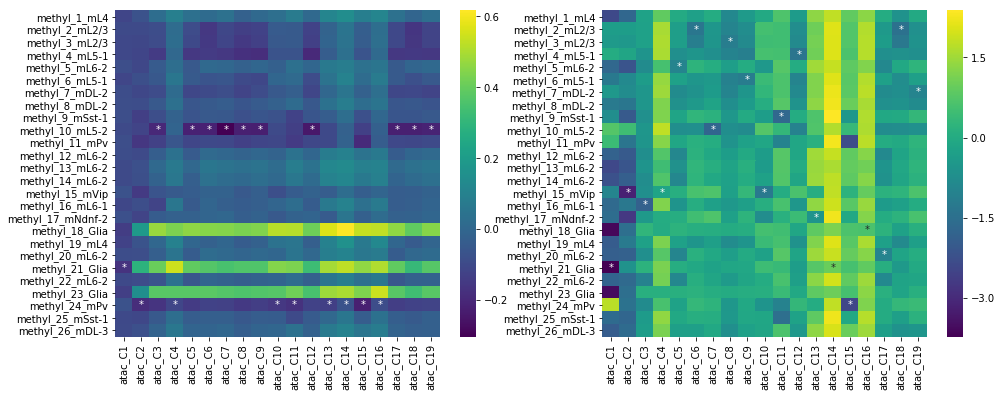

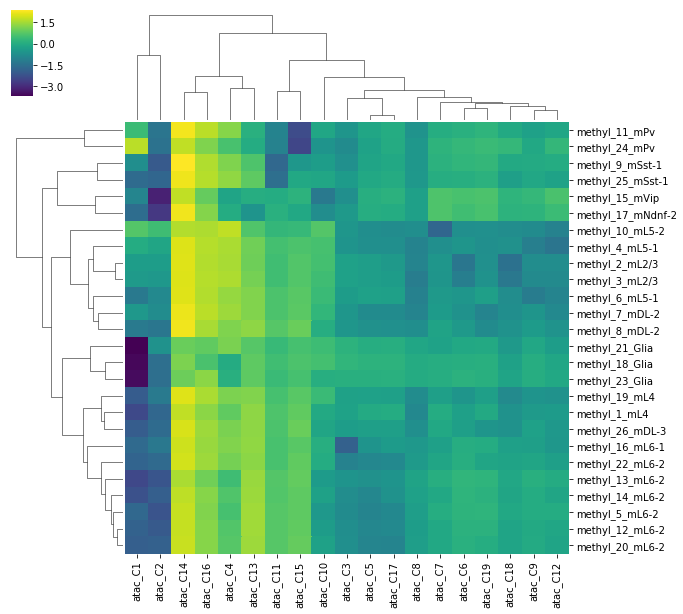

In [47]:
df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
# df_corr = df_corr.T
reject_threshold = 1000

df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
for col, idx in df_corr.idxmin().iteritems():
    if df_corr.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot = df_annot.fillna('')

df_corr_zscore = df_corr.apply(zscore, axis=1)
df_annot_zscore = pd.DataFrame(columns=df_corr_zscore.columns, index=df_corr_zscore.index)
for col, idx in df_corr_zscore.idxmin().iteritems():
    if df_corr_zscore.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot_zscore.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot_zscore = df_annot_zscore.fillna('')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, annot=df_annot, fmt='', ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr_zscore, annot=df_annot_zscore, fmt='', ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/1.pdf')
plt.show()


sns.clustermap(df_corr_zscore, cmap='viridis')
plt.savefig('/cndd/fangming/integration/1-1.pdf')
plt.show()

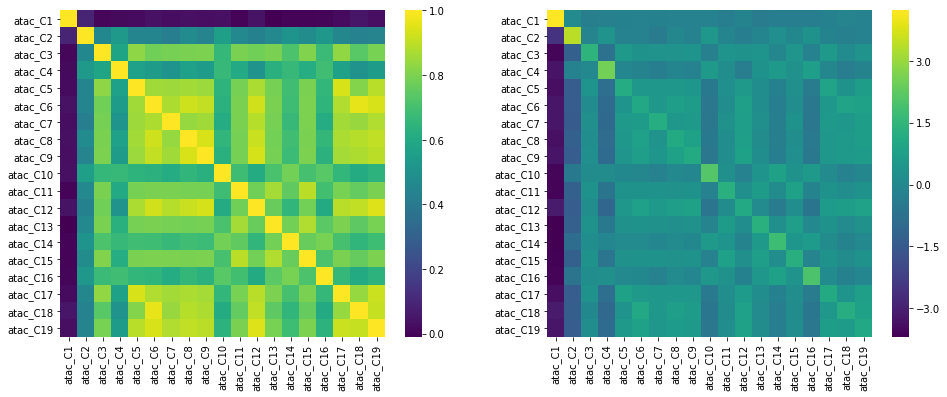

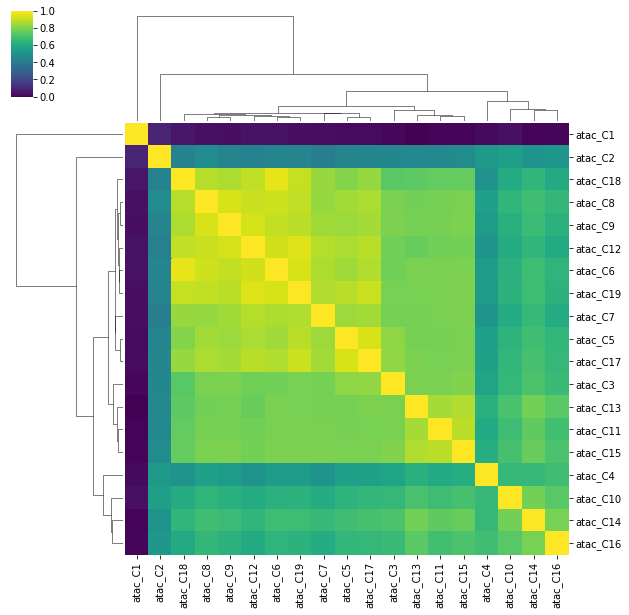

In [48]:
df_corr = pd.DataFrame(corr[:nclst_atac, :nclst_atac], index=data_atac.columns, columns=data_atac.columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/2.pdf')
plt.show()

sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
plt.savefig('/cndd/fangming/integration/2-1.pdf')
plt.show()


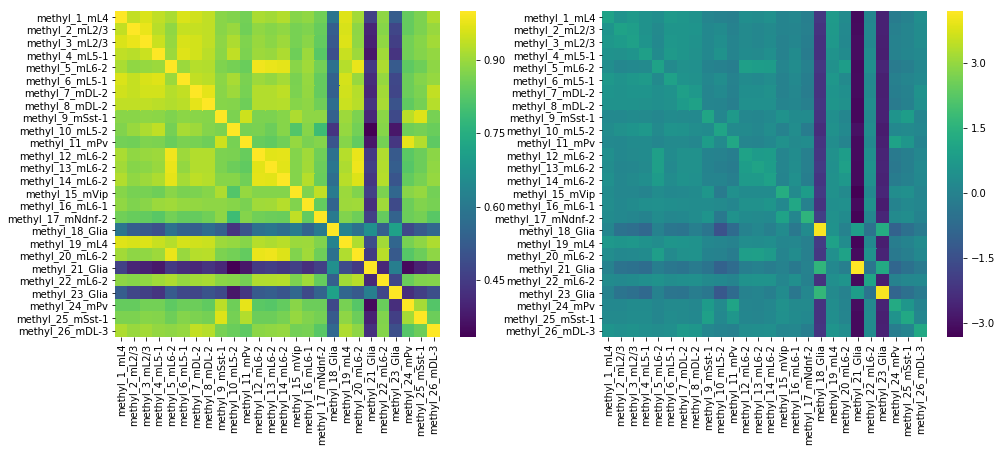

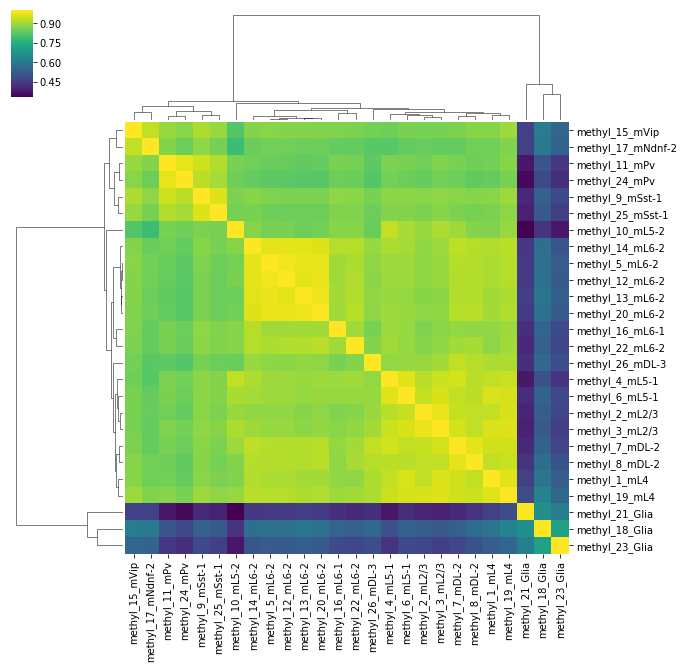

In [262]:
df_corr = pd.DataFrame(corr[nclst_atac:, nclst_atac:], index=data_mcc.columns, columns=data_mcc.columns)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/3.pdf')
plt.show()


sns.clustermap(df_corr, cmap='viridis', col_cluster=True)
plt.savefig('/cndd/fangming/integration/3-1.pdf')
plt.show()

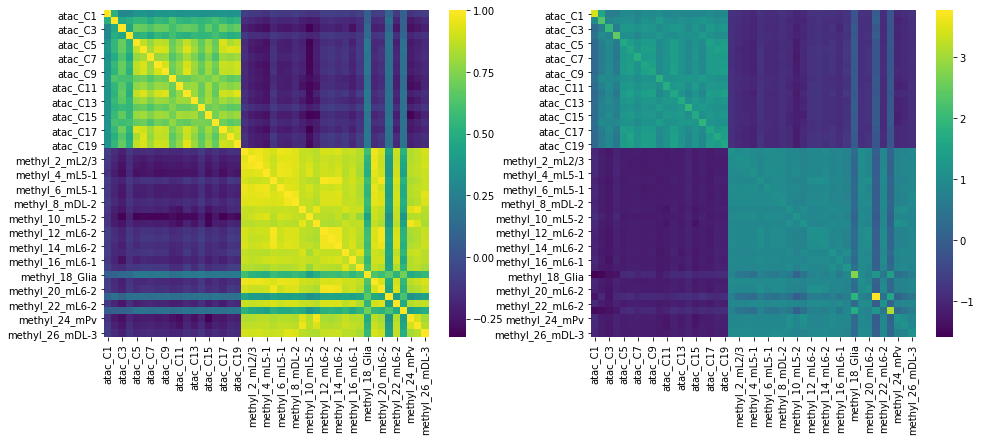

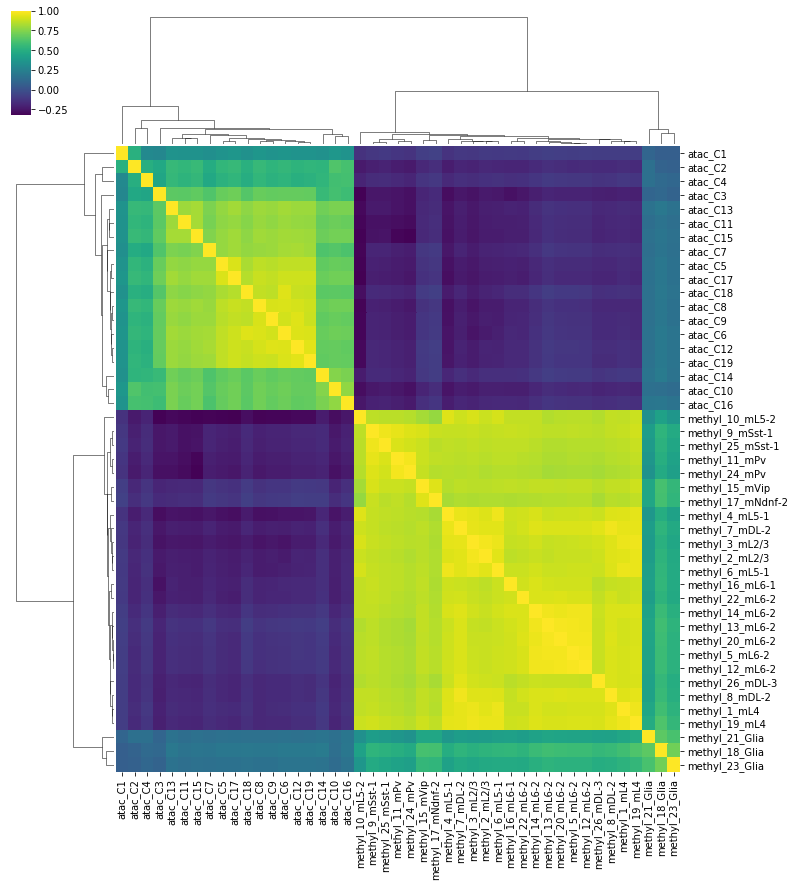

In [263]:
df_corr = pd.DataFrame(corr, 
                       index=data_atac.columns.tolist() + data_mcc.columns.tolist(),
                       columns=data_atac.columns.tolist() + data_mcc.columns.tolist())
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_corr, ax=ax, cmap='viridis')
ax = axs[1]
sns.heatmap(df_corr.apply(zscore, axis=1), ax=ax, cmap='viridis')
fig.savefig('/cndd/fangming/integration/4.pdf')
plt.show()


sns.clustermap(df_corr, cmap='viridis', col_cluster=True, figsize=(12, 14))
plt.savefig('/cndd/fangming/integration/4-1.pdf')
plt.show()

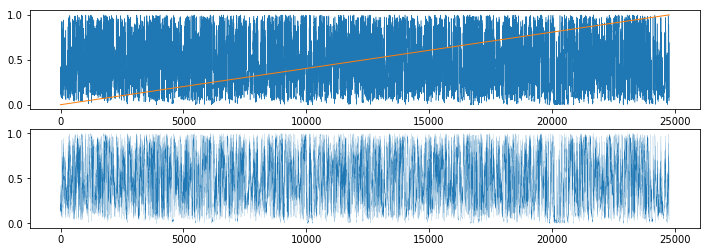

In [169]:
fig, axs = plt.subplots(2, 1, figsize=(12, 4))
ax = axs[0]
ax.plot(data_mcc['methyl_1'].values, linewidth=0.5)
ax.plot(data_mcc.loc[data_mcc['methyl_1'].sort_values().index, 'methyl_1'].values, linewidth=1)
ax = axs[1]
ax.plot(data_mcc['methyl_1'].values, linewidth=0.1)
plt.show()